## SAMHAR - COVID-19

## 1. Introduction - Overview of problem and approach

Data plays a pivotal role in designing any authentic AI solutions, especially when it comes to finding a potential drug which can help as a vaccine or drug for any diseases. In order to create a Deep Learning architecture, we reviewed various research articles and journals which were authentic and recently published considering the protease structure of COVID-19 and its potential inhibitors. One of the most significant literature is “Structure of Mpro from COVID-19 virus and discovery of its inhibitors” 
( Reference: https://www.nature.com/articles/s41586-020-2223-y ). Researchers have identified a mechanism-based inhibitor, N3, by computer-aided drug design and subsequently determined the crystal structure of COVID-19 virus Mpro in complex with this compound. “ N3 is a potent irreversible inhibitor of COVID-19 virus Mpro”.
Next, through a combination of structure-based virtual and high-throughput screening, over 10,000 compounds have been assayed including approved drugs, drug candidates in clinical trials, and other pharmacologically active compounds as inhibitors of Mpro . Six of these compounds inhibited Mpro with IC50 values ranging from 0.67 to 21.4 μM. Ebselen also exhibited promising antiviral activity in cell-based assays. 


Taking a proper look at the research findings, it can be taken into consideration that most compound exhibit similar structure and properties to N3 and also certain FDA approved drugs which are currently being used for the cure of HIV  can act as a potential inhibitor

Here, we design a composite Deep Learning based Neural Architecture which uses two approaches - Predictive and Generative. These can help us in predicting potential drugs from FDA approved drug databases using Predictive Network as well as in generating new molecules based on similar structure and chemical properties using a Generative network. 


### Predictive Approach

A Predictive Deep Neural Network : 
	
A list of pubchem compounds with unknown activities is then used to predict activities.

( Reference: Predictive deep learning model using an "Edge Memory Neural Network", described herein https://chemrxiv.org/articles/Building_Attention_and_Edge_Convolution_Neural_Networks_for_Bioactivity_and_Physical-Chemical_Property_Prediction/9873599 and implemented at https://github.com/edvardlindelof/graph-neural-networks-for-drug-discovery.)

### Generative Approach

We propose a novel "Inter-leaved GAN Architecture” ( A new inner GAN Architecture inside the Generator of the outer GAN) .The aim of this model is to subsequently sample the latent space to generate new graphs based on the attributes of the compounds which show some inhibition property to the COVID-19 Mpro protease and also by combining two or more publicly available and approved datasets like Moses, ChEMBL, Harmonizome etc. The generated compounds may not be FDA approved as of now but can be synthesized further and lab trials can be conducted.

(Reference: Constrained Graph Variational Autoencoder", described herein https://arxiv.org/pdf/1805.09076.pdf )


## 2. Dataset - Finding relevant compounds with activities

SARS and MERS are both coronavirus variants that are very similar and since their respective outbreaks, many biological assays have been done to test compounds on their main proteases. Bioactivities measured in papers by medicinal chemists and biochemists are tracked by The National Center for Biotechnology Information (NCBI) and are freely available. A database of protease inhibitors will be built using this data.

### General Dataset Preparation

The dataset generation begins by simply seaching the NCBI website, bioassay search found at https://www.ncbi.nlm.nih.gov/pcassay/advanced, to try and find relevant assays. Results from any search can be "sent to" a file (Shown below)

We use the NCBI website to download different assays based on different targets, we searched various different kind of targets to get different assays and at last, we have a large list of assays and then get the molecular structure of the assays because the assays don’t have SMILE strings in them, they just have compound IDs
(link: https://www.ncbi.nlm.nih.gov/pcassay/advanced )

As these targets are RNA proteinase, and RNA proteinase is also present in COVID1, the ligands which bind to this proteinase can bind to COVID19 proteinase up to some significant extent

The searches we used to generate a good AID (assay ID’s)  list are:

    (1) Protein target GI73745819 - SARS Protease - Called SARS_C3_Assays.txt in this report

    (2) Protein target GI75593047 - HIV pol polyprotein - Called HIV_Protease_Assays.txt in this report

    (3) NS3 - Hep3 protease -  Called NS3_Protease_Assays.txt in this report

    (4) 3CL-Pro - Mers Protease -  Called MERS_Protease_Assays.txt in this report


In [0]:
! grep AID Data/SARS_C3_Assays.txt > Data/SARS_C3_Assays_AID_only.csv

In [0]:
! sed -i 's/[^0-9]//g' Data/SARS_C3_Assays_AID_only.csv

In [0]:
#Imports
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.DataStructs import cDataStructs
import numpy as np
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import os
import time
import pickle
import csv
from rdkit.Chem import QED
import random
import json
from sklearn.preprocessing import StandardScaler

In [0]:
def get_assays(assay_path, assay_pickle_path):
    with open(str(assay_path)) as f:
        r = csv.reader(f)
        AIDs = list(r)
    assays = []
    for i, AID in zip(range(len(AIDs)), AIDs):
        os.system('curl https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%s/sdf -o cmp.sdf' %CID)
        if os.stat(f'Data/assay.csv').st_size != 0:
            assays.append(pd.read_csv(f'Data/assay.csv'))

    pickle.dump(assays, open(str(assay_pickle_path), "wb"))

def get_mols_for_assays(assays_no_mol_path, assays_with_mol_path):
    assays = pickle.load(open(str(assays_no_mol_path), "rb"))
    for assay in assays:
        if len(assay) != 1:
            cids = list(assay[['PUBCHEM_CID']].values.astype("int32").squeeze())
            nan_counter = 0
            for i in range(len(cids)):
                if cids[i] < 0:
                    nan_counter += 1
                else:
                    break
            cids = cids[nan_counter:]
            mols = []
            for CID in cids:
                os.system('curl https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%s/sdf -o cmp.sdf' %CID)
                if os.stat(f'Data/cmp.sdf').st_size != 0:
                    mols.append(Chem.SDMolSupplier("Data/cmp.sdf")[0])
                else:
                    mols.append(None)

            for i in range(nan_counter):
                mols.insert(0,None)

            assay.insert(3, "Mol Object", mols)

    pickle.dump(assays, open(str(assays_with_mol_path), "wb"))

In [0]:
get_assays("Data/SARS_C3_Assays_AID_only.csv", "Data/sars/sars_assays_no_mol.pkl")

In [0]:
get_mols_for_assays("Data/sars/sars_assays_no_mol.pkl", "Data/sars/sars_assays.pkl")

In [0]:
get_assays_no_mol("Data/MERS_Protease_Assays_AID_only.csv", "Data/mers/mers_assays_no_mol.pkl")
get_mols_for_assay("Data/mers/mers_assays_no_mol.pkl", "Data/mers/mers_assays.pkl")
get_assays_no_mol("Data/NS3_Protease_Assays_AID_only.csv", "Data/ns3/ns3_assays_no_mol.pkl")
get_mols_for_assay("Data/ns3/ns3_assays_no_mol.pkl", "Data/ns3/ns3_assays.pkl")
get_assays_no_mol("Data/HIV_Protease_Assays_AID_only.csv", "Data/hiv/hiv_assays_no_mol.pkl")
get_mols_for_assay("Data/hiv/hiv_assays_no_mol.pkl", "Data/hiv/hiv_assays.pkl")

In [0]:
assays = {}
assays["sars"] = pickle.load(open("Data/sars/sars_assays.pkl", "rb"))
assays["mers"] = pickle.load(open("Data/mers/mers_assays.pkl", "rb"))
assays["ns3"] = pickle.load(open("Data/ns3/ns3_assays.pkl", "rb"))
assays["hiv"] = pickle.load(open("Data/hiv/hiv_assays.pkl", "rb"))

It is worth mentioning here the different kinds of Bioactivities that an assay can report. Depending on what was relevant to the scientists involved in the study, various values can be used. Possibly most importantly for generating this dataset though is to not confuse the different kinds of activities. We will focus on IC50, which is the concentration of the compound at which 50% inhibition is observed. The value is normally reported as a "Micromolar concentration". The lower the value, the better the compound is at inhibiting the protein. It is important to not be tempted to use the "Activity" reported in some assays, which is normally a % and corresponds to how much that compound inhibits the protein at a given concentration. We're sticking with IC50 because this value is very information-rich and actually many "Activity" experiments go into producing 1 IC50 value. Also, they are more easily comparable, as we don't need to standardize concentration across the assays. For this report, we will focus on the "PubChem Standard Value" which is normally a  standardized value using some metric (we will further narrow to only the metrics we want)

In [0]:
for a in ["sars", "mers", "ns3", "hiv"]:
    print("Length of",str(a),"before removing")
    print(len(assays[a]))
    assays[a] = np.array(assays[a])
    bad_list = []
    good_list = []
    for i in range(len(assays[a])):
        ic50_cols = [col for col in assays[a][i].columns if 'PubChem Standard Value' in col]
        if not ic50_cols:
            bad_list.append(i)
        else:
            good_list.append(int(i))

    bad_list = np.array(bad_list)
    good_list = np.array(good_list, dtype='int32')

    assays[a] = assays[a][good_list]
    print("Length of",str(a),"after removing")
    print(len(assays[a]))

Length of sars before removing
13
Length of sars after removing
0
Length of mers before removing
7
Length of mers after removing
4
Length of ns3 before removing
3252
Length of ns3 after removing
1305
Length of hiv before removing
582
Length of hiv after removing
580


In [0]:
for a in ["sars", "mers", "ns3", "hiv"]:
    for i in range(len(assays[a])):
        assays[a][i] = assays[a][i][["Mol Object", "PubChem Standard Value", "Standard Type"]]

In [0]:
for a in ["sars", "mers", "ns3", "hiv"]:
    for i in range(len(assays[a])):
        print(assays[a][i][["Standard Type"]].values[-1])

You can see that even the "standard" values can have quite a variance in what they mean. As mentioned above, we will focus on only IC50 values. We know from enzyme kinetics that when a ligand binds to a protein in an uncompetetive scenario (i.e. an assay) the Ki value determined is equal to the IC50, so we can include it too. Also the Kd value is a more general way of referring to the Ki value, so it can be included. Finally, we add IC90 values, which are defined similar to IC50 values, but for 90% inhibition. This was done to increase the size of the dataset, knowing that it will unfortunately introduce bias into our model. The justification for doing this is that the units are the same, and that there's a good change that a compound with a low IC90 will have a low IC50

In [0]:
all_dfs = []
for a in ["sars", "mers", "ns3", "hiv"]:
    for i in range(len(assays[a])):
        if assays[a][i][["Standard Type"]].values[-1][0] in {"IC50", "Ki", "Kd", "IC90"}:
            all_dfs.append(assays[a][i])

In [0]:
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i].iloc[4:]
final_df = pd.concat(all_dfs)

In [0]:
final_df['PubChem Standard Value'] = final_df['PubChem Standard Value'].astype(float)
df = final_df[final_df["PubChem Standard Value"] < 0.1]

In [0]:
pickle.dump(df, open("Data/final_df.pkl", "wb"))

### Method Specific-preparation

Now moving on to preparing the dataset for use in the predictive model as well as the generative model

In [0]:
df = pickle.load(open("Data/final_df.pkl", "rb"))

In [0]:
df.insert(3, 'smiles', [Chem.MolToSmiles(x) for x in df[['Mol Object']].values[:,0]], True)
df.insert(4, 'qed', [QED.qed(x) for x in df[['Mol Object']].values[:,0]], True)

In [0]:
salt_indexes = []
for i in range(len(df)):
    if "." in df[["smiles"]].values[i][0]:
        salt_indexes.append(i)

In [0]:
df = df.reset_index()
df = df.drop(df.index[salt_indexes])

df[["smiles", "qed"]].to_csv("Data/250k_rndm_zinc_drugs_clean_3.csv", index=False)
new_valid_idx = random.sample(range(len(df)), int(len(df)*0.1))
new_valid_idx.sort()
with open("Data/valid_idx_zinc.json", 'w') as f:
    json.dump(new_valid_idx, f)

In [0]:
df.insert(2, 'log_std', [-np.log10(x) for x in df[['PubChem Standard Value']].values[:,0]], True)
#plt.hist(df[['log_std']].values[:,0], bins=25)

In [0]:
scaler = StandardScaler()
scaler.fit(df[['log_std']].values[:,0].reshape(-1, 1))
df.insert(2, 'log_std_scaled', scaler.transform(df[['log_std']].values[:,0].reshape(-1, 1)), True)

In [0]:
data = df[["smiles", "log_std_scaled"]].values
np.random.shuffle(data)
train, valid, test = np.split(data, [int(.8*data.shape[0]), int(.9*data.shape[0])])
train = np.insert(train, 0, [None]*train.shape[0], 1)
valid = np.insert(valid, 0, [None]*valid.shape[0], 1)
test = np.insert(test, 0, [None]*test.shape[0], 1)

In [0]:
pd.DataFrame(train).to_csv("Data/protease_train.csv.gz", index=False, compression='gzip', sep='\t')
pd.DataFrame(valid).to_csv("Data/protease_valid.csv.gz", index=False, compression='gzip', sep='\t')
pd.DataFrame(test).to_csv("Data/protease_test.csv.gz", index=False, compression='gzip', sep='\t')

## 4. Bioactivity Prediction - Edge Memory Neural Network

Outline of this section: First we train the model using the dataset obtained in section 2. Then we can use the trained model to look at commercially available libraries of molecules where it would be impossible to do docking studies on each compound. In this way, the machine learning model serves to "thin the herd" of potential compounds so that we can identify candidates for docking studies.

### Training the model

In [0]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import EMNN.gnn

import EMNN.gnn.emn_implementations
from EMNN.losses import LOSS_FUNCTIONS
from EMNN.train_logging import LOG_FUNCTIONS
from EMNN.gnn.molgraph_data import MolGraphDataset, molgraph_collate_fn
from EMNN.train_logging import feed_net
from EMNN.train_logging import compute_mse
import datetime

In [0]:
train_dataset = MolGraphDataset('Data/protease_train.csv.gz')
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, collate_fn=molgraph_collate_fn)
validation_dataset = MolGraphDataset('Data/protease_valid.csv.gz')
validation_dataloader = DataLoader(validation_dataset, batch_size=50, collate_fn=molgraph_collate_fn)
test_dataset = MolGraphDataset('Data/protease_test.csv.gz')
test_dataloader = DataLoader(test_dataset, batch_size=50, collate_fn=molgraph_collate_fn)

In [0]:
((sample_adjacency, sample_nodes, sample_edges), sample_target) = train_dataset[0]

net = EMNN.gnn.emn_implementations.EMNImplementation(node_features=len(sample_nodes[0]), 
                                                edge_features=len(sample_edges[0, 0]), 
                                                out_features=len(sample_target), 
                                                message_passes=8, edge_embedding_size=50, 
                                                edge_emb_depth=2, edge_emb_hidden_dim=150, 
                                                edge_emb_dropout_p=0.0, att_depth=2, att_hidden_dim=85, 
                                                att_dropout_p=0.0, msg_depth=2, msg_hidden_dim=150, 
                                                msg_dropout_p=0.0, gather_width=45, gather_att_depth=2, 
                                                gather_att_hidden_dim=45, gather_att_dropout_p=0.0, 
                                                gather_emb_depth=2, gather_emb_hidden_dim=45, 
                                                gather_emb_dropout_p=0.0, out_depth=2, out_hidden_dim=450, 
                                                out_dropout_p=0.1, out_layer_shrinkage=0.6)
                                                
if True:
    net = net.cuda()

optimizer = optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [0]:
SAVEDMODELS_DIR = "EMNN/savedmodels/"
def evaluate_net(net, train_dataloader, validation_dataloader, test_dataloader, criterion):
    global evaluate_called
    global DATETIME_STR
    global best_mean_train_score
    global best_mean_validation_score
    global best_mean_test_score
    global train_subset_loader
    
    if not evaluate_called:
        evaluate_called = True
        best_mean_train_score, best_mean_validation_score, best_mean_test_score = 10, 10, 10
        train_subset_loader = train_dataloader

    train_output, train_loss, train_target = feed_net(net, train_subset_loader, criterion, True)
    validation_output, validation_loss, validation_target = feed_net(net, validation_dataloader, criterion, True)
    test_output, test_loss, test_target = feed_net(net, test_dataloader, criterion, True)

    train_scores = compute_mse(train_output, train_target)
    train_mean_score = np.nanmean(train_scores)
    validation_scores = compute_mse(validation_output, validation_target)
    validation_mean_score = np.nanmean(validation_scores)
    test_scores = compute_mse(test_output, test_target)
    test_mean_score = np.nanmean(test_scores)

    new_best_model_found = validation_mean_score < best_mean_validation_score

    if new_best_model_found:
        best_mean_train_score = train_mean_score
        best_mean_validation_score = validation_mean_score
        best_mean_test_score = test_mean_score

        path = SAVEDMODELS_DIR + type(net).__name__ + DATETIME_STR
        torch.save(net, path)

    target_names = train_dataloader.dataset.target_names
    return {  # NOTE for Chintan : if made deeper, tensorboardx writing breaks
        'loss': {'train': train_loss, 'test': test_loss},
        'mean {}'.format("MSE"):
            {'train': train_mean_score, 'validation': validation_mean_score, 'test': test_mean_score},
        'train {}s'.format("MSE"): {target_names[i]: train_scores[i] for i in range(len(target_names))},
        'test {}s'.format("MSE"): {target_names[i]: test_scores[i] for i in range(len(target_names))},
        'best mean {}'.format("MSE"):
            {'train': best_mean_train_score, 'validation': best_mean_validation_score, 'test': best_mean_test_score}
    }

In [0]:
def less_log(net, train_dataloader, validation_dataloader, test_dataloader, criterion, epoch):
    scalars = evaluate_net(net, train_dataloader, validation_dataloader, test_dataloader, criterion)
    mean_score_key = 'mean {}'.format("MSE")
    print('epoch {}, training mean {}: {}, validation mean {}: {}, testing mean {}: {}'.format(
        epoch + 1,
        "MSE", scalars[mean_score_key]['train'],
        "MSE", scalars[mean_score_key]['validation'],
        "MSE", scalars[mean_score_key]['test'])
    )

In [0]:
evaluate_called = False
best_mean_train_score, best_mean_validation_score, best_mean_test_score = 10, 10, 10
train_subset_loader = None
DATETIME_STR = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

for epoch in range(10):
    net.train()
    for i_batch, batch in enumerate(train_dataloader):

        if True:
            batch = [tensor.cuda() for tensor in batch]
        adjacency, nodes, edges, target = batch

        optimizer.zero_grad()
        output = net(adjacency, nodes, edges)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_value_(net.parameters(), 5.0)
        optimizer.step()

    with torch.no_grad():
        net.eval()
        less_log(net, train_dataloader, validation_dataloader, test_dataloader, criterion, epoch)

epoch 1, training mean MSE: 0.8951175212860107, validation mean MSE: 0.9061940312385559, testing mean MSE: 0.8469619750976562
epoch 2, training mean MSE: 0.977311372756958, validation mean MSE: 0.9557181596755981, testing mean MSE: 0.9650275111198425
epoch 3, training mean MSE: 1.1798733472824097, validation mean MSE: 1.139570713043213, testing mean MSE: 1.1391936540603638
epoch 4, training mean MSE: 0.8452802896499634, validation mean MSE: 0.7715051770210266, testing mean MSE: 0.8197449445724487
epoch 5, training mean MSE: 0.8078230023384094, validation mean MSE: 0.7321721911430359, testing mean MSE: 0.7933482527732849
epoch 6, training mean MSE: 0.807136595249176, validation mean MSE: 0.7541796565055847, testing mean MSE: 0.7905585169792175
epoch 7, training mean MSE: 0.7677217125892639, validation mean MSE: 0.7257513999938965, testing mean MSE: 0.7519866228103638
epoch 8, training mean MSE: 0.9953380227088928, validation mean MSE: 0.9657719731330872, testing mean MSE: 0.955113768577

### Predictions

In [0]:
def predict(test_set):
    with torch.no_grad():
        net = torch.load("EMNN/savedmodels/EMNImplementation2020-03-01 17:49:07.529952")
        if True:
            net = net.cuda()
        else:
            net = net.cpu()
        net.eval()

        dataset = MolGraphDataset(test_set, prediction=True)
        dataloader = DataLoader(dataset, batch_size=50, collate_fn=molgraph_collate_fn)

        batch_outputs = []
        for i_batch, batch in enumerate(dataloader):
            if True:
                batch = [tensor.cuda() for tensor in batch]
            adjacency, nodes, edges, target = batch
            batch_output = net(adjacency, nodes, edges)
            batch_outputs.append(batch_output)

        output = torch.cat(batch_outputs).cpu().numpy()
        
        df = pd.read_csv(test_set)
        
        df.insert(1, 'pred_log_std_scaled', output, True)
        
        return df

In [0]:
predict("Data/protease_test.csv.gz")

,0\t1\t2,pred_log_std_scaled
0,\tC=C[C@@H]1C[C@]1(NC(=O)[C@@H]1C[C@@]2(CN1C(=...,0.010454
1,\tCn1cc(CN2CCN(C[C@@H](O)C[C@@H](Cc3ccccc3)C(=...,0.980469
2,\tNC(=O)c1cccc(CN2C(=O)N[C@H](CCc3ccccc3)[C@@H...,0.431882
3,\tCCC1CCCCCCc2c1oc(=O)c(C(c1ccccc1)C1CC1)c2O\t...,-0.994734
4,\tCNC(=O)c1c2cc(C3CC3)c(N(CCCN3CCOCC3)S(C)(=O)...,-0.532564
...,...,...
670,\tCCC[C@H](NC(=O)[C@@H]1C[C@@H](OC(=O)N2Cc3ccc...,-0.152789
671,\tCNC(=O)c1c(-c2ccc(F)cc2)oc2cc(N(C)S(C)(=O)=O...,-0.463377
672,\tCCCC1(CCc2ccccc2)CC(O)=C(C(CC)c2cccc(NS(=O)(...,-0.146949
673,\tCC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C...,0.027629


The N3 ligand from the crystal structure was extracted and its smiles string was searched on pubchem to find similar structures, which were saved and their activities can be predicted using the newly trained model

In [0]:
sim_compound = pd.read_csv("Data/n3_similar_compounds.csv")
cids = list(sim_compound[['cid']].values.astype("int32").squeeze())

In [0]:
mols = []
for CID in cids:
    os.system('curl https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%s/sdf -o Data/cmp.sdf' %CID)
    if os.stat(f'Data/cmp.sdf').st_size != 0:
        mols.append(Chem.SDMolSupplier("Data/cmp.sdf")[0])
    else:
        mols.append(None)

In [0]:
sim_df = pd.DataFrame(mols)

In [0]:
sim_df.insert(0, 'smiles', [Chem.MolToSmiles(x) for x in sim_df[[0]].values[:,0]], True)

In [0]:
sim_df.insert(0, 'empty', [None]*len(sim_df), True)

In [0]:
sim_df[["empty","smiles"]].to_csv("Data/n3_similarity_test.csv.gz", index=False, compression='gzip', sep='\t')

In [0]:
predict("Data/n3_similarity_test.csv.gz")

,empty\tsmiles,pred_log_std_scaled
0,\tCCOC(=O)CCC(CC1CCNC1=O)NC(=O)C(CC(=O)C(NC(=O...,-0.823031
1,\tCCOC(=O)C=C[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccc...,-0.140704
2,\tCCOC(=O)C=C[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccc...,-0.349544
3,\tCCOC(=O)C=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,0.118348
4,\tCCOC(=O)C=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,-0.087631
...,...,...
183,\tCC(C)C.CC[C@H](NC(=O)CNC(=O)[C@H](CCOC)NC(=O...,-0.484806
184,\tCC.CCOC(=O)c1cc(CCNC(=O)c2cc(-c3ccccc3)on2)on1,-0.680866
185,\tCC(=O)NC(C)(C)C.Cc1cc(C(=O)NCC(=O)OCc2ccccc2...,-0.706690
186,\tCOC1CC1(NC(=O)c1cc(C)on1)C(=O)N[C@@H](C)C(=O...,0.125349


In [0]:
predictions = predict("Data/n3_similarity_test.csv.gz")

In [0]:
predictions.sort_values("pred_log_std_scaled", ascending=False)

,empty\tsmiles,pred_log_std_scaled
81,\t[2H]N1CC[C@@H](C[C@@H](/C=C2\CCOC2=O)NC(=O)[...,1.168798
102,\t[2H]N1CC[C@@H](C[C@@H](C=C2CCOC2=O)NC(=O)[C@...,1.168798
29,\tCC[C@@H](C(=O)N[C@H](/C=C/C(=O)OCc1ccccc1)C[...,0.954340
82,\tCc1cc(C(=O)Nc2cccn([C@@H](Cc3ccc(F)cc3)C(=O)...,0.949556
110,\tCc1cc(C(=O)Nc2cccn([C@@H](Cc3ccc(F)cc3)C(=O)...,0.949556
...,...,...
76,\tCCCCOCCCNC(=O)CNC(=O)c1cc(-c2ccccc2)on1,-0.900945
71,\tCOC(=O)C(CC(C)C)NC(=O)c1cc(-c2ccccc2)on1,-0.914809
67,\tCOC(=O)C(CC(C)C)NC(=O)CNC(=O)c1cc(-c2ccccc2)on1,-0.915312
70,\tCC(C)OC(=O)CCNC(=O)c1cc(-c2ccccc2)on1,-0.922215


Because we have no way of verifying the accuracy of the predicted values for these compounds, we're going to instead just take the 10 highest predicted compounds and dock them using Autodock, By doing this we actually don't even need to re-scale the scaled standard activity value, we can just take the compounds knowing that why were predicted to be the best

In [0]:
#Keeping the best 10 compounds
best_predicted = predictions[["empty\tsmiles"]].values[:10,0]

In [0]:
best_predicted = [best_predicted[i][1:] for i in range(len(best_predicted))]

In [0]:
pickle.dump(best_predicted, open("Data/best_predicted_smiles.pkl", "wb"))

## 5. Molecular Generation I - Constrained Graph Variational Autoencoder

This approach is detailed in the paper: "Constrained Graph Variational Autoencoders for Molecule Design" available here: https://arxiv.org/abs/1805.09076

Outline of this section: First we train the model using the dataset obtained in section 2. Using the built-in generation phase of the VAE, we generate new compounds and consider some of them as candidiates. The design of the method allows for optimization in the latent space, by doing gradient accent on a target value. This was not employed and random sampling generation was used.

In [0]:
import tensorflow as tf
from typing import Sequence, Any
from docopt import docopt
from collections import defaultdict, deque
import sys, traceback
import pdb
from CGVAE.CGVAE import DenseGGNNChemModel
from CGVAE.GGNN_core import ChemModel
import CGVAE.utils
from CGVAE.utils import *
from numpy import linalg as LA
from copy import deepcopy
from CGVAE.data_augmentation import *

In [0]:
def train_valid_split(download_path):
    # load validation dataset
    with open("Data/valid_idx_zinc.json", 'r') as f:
        valid_idx = json.load(f)

    print('reading data...')
    raw_data = {'train': [], 'valid': []} 
    with open(download_path, 'r') as f:
        all_data = list(csv.DictReader(f))

    file_count=0
    for i, data_item in enumerate(all_data):
        smiles = data_item['smiles'].strip()
        QED = float(data_item['qed'])
        if i not in valid_idx:
            raw_data['train'].append({'smiles': smiles, 'QED': QED})
        else:
            raw_data['valid'].append({'smiles': smiles, 'QED': QED})
        file_count += 1
        if file_count % 2000 ==0:
            print('finished reading: %d' % file_count, end='\r')
    return raw_data

def preprocess(raw_data, dataset):
    print('parsing smiles as graphs...')
    processed_data = {'train': [], 'valid': []}
    
    file_count = 0
    for section in ['train', 'valid']:
        all_smiles = [] 
        for i,(smiles, QED) in enumerate([(mol['smiles'], mol['QED']) 
                                          for mol in raw_data[section]]):
            nodes, edges = to_graph(smiles, dataset)
            if len(edges) <= 0:
                continue
            processed_data[section].append({
                'targets': [[(QED)]],
                'graph': edges,
                'node_features': nodes,
                'smiles': smiles
            })
            all_smiles.append(smiles)
            if file_count % 2000 == 0:
                print('finished processing: %d' % file_count, end='\r')
            file_count += 1
        print('%s: 100 %%      ' % (section))
        # save the dataset
        with open('Data/molecules_%s_%s.json' % (section, dataset), 'w') as f:
            json.dump(processed_data[section], f)
        if section == 'train':
            CGVAE.utils.dump('Data/smiles_%s.pkl' % dataset, all_smiles)  

In [0]:
path = 'Data/250k_rndm_zinc_drugs_clean_3.csv'
raw_data = train_valid_split(path)
preprocess(raw_data, 'zinc')

reading data...
parsing smiles as graphs...
unrecognized atom type P5(0)
unrecognized atom type P5(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type P5(0)
unrecognized atom type P5(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)
unrecognized atom type B3(0)

In [0]:
args = {'--config': None,
 '--config-file': None,
 '--data_dir': 'Data/',
 '--dataset': 'zinc',
 '--freeze-graph-model': False,
 '--help': False,
 '--log_dir': 'CGVAE/',
 '--restore': 'CGVAE/10_zinc.pickle'}

In [0]:
model = DenseGGNNChemModel(args)
model.train()

## 6. Validation - Molecular Docking Studies Using Autodock Vina

### Re-docking the N3 Ligand as a baseline

First step in the validation of proposed structures is to re-dock the N3 ligand into the protease structure, to get a baseline for the energy score associated with their binding. It is important to note that the N3 ligand shown in the X-Ray structure is a covalent inhibitor, which means it actually reacts with the active site of the protein. This results in a much stronger bond between ligand and target than non-covalent inhibition. 

This means that the re-docked structure may not be the same as the x-ray, since it lacks the covalent bond to the protein. The following in a procedure for the docking of the N3 ligand into the protein receptor. The same procedure is used for all fo the alter dockings of the candidate molecules. The procedure requires 3 programs:

Pymol - https://pymol.org/2/ or https://github.com/schrodinger/pymol-open-source

Autodock Vina - http://vina.scripps.edu/download.html

Autodock Tools, found in MGL tools - http://mgltools.scripps.edu/downloads


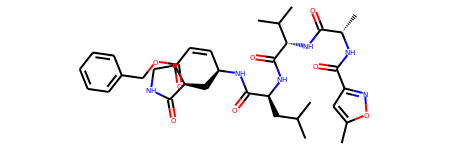

In [0]:
#Visualizing the N3 ligand
Chem.MolFromSmiles("CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)c1cc(C)on1)C(C)C)C(=O)N[C@@H](C[C@@H]2CCNC2=O)\C=C/C(=O)OCc3ccccc3")

Following this procedure for the N3 ligand, we end up with a final lowest energy minimum of around -7.9kcal/mol. The exact value doesn't tell us much, because the specific parameters of the docking scoring function can vary, but this serves as a baseline for comparison of later candidates. The following is the lowest energy stucture. You can see that it is in fact very different from the X-ray structure due to the lack of the covalent bond to the protein, with the N3 ligand sort of "bending back" in this conformation

![N3_redocked_with_flex.png](attachment:N3_redocked_with_flex.png)

Now for docking the candidates. The same procedure as above was followed for each of the candidates, with the additional step below of loading the structures and saving them as PDB files, to be opened in AutoDockTools

### Preparing the high scoring and generated compounds for docking

In [0]:
best_predicted = pickle.load(open("Data/best_predicted_smiles.pkl", "rb"))

In [0]:
best_predicted_mols = [Chem.MolFromSmiles(x) for x in best_predicted]

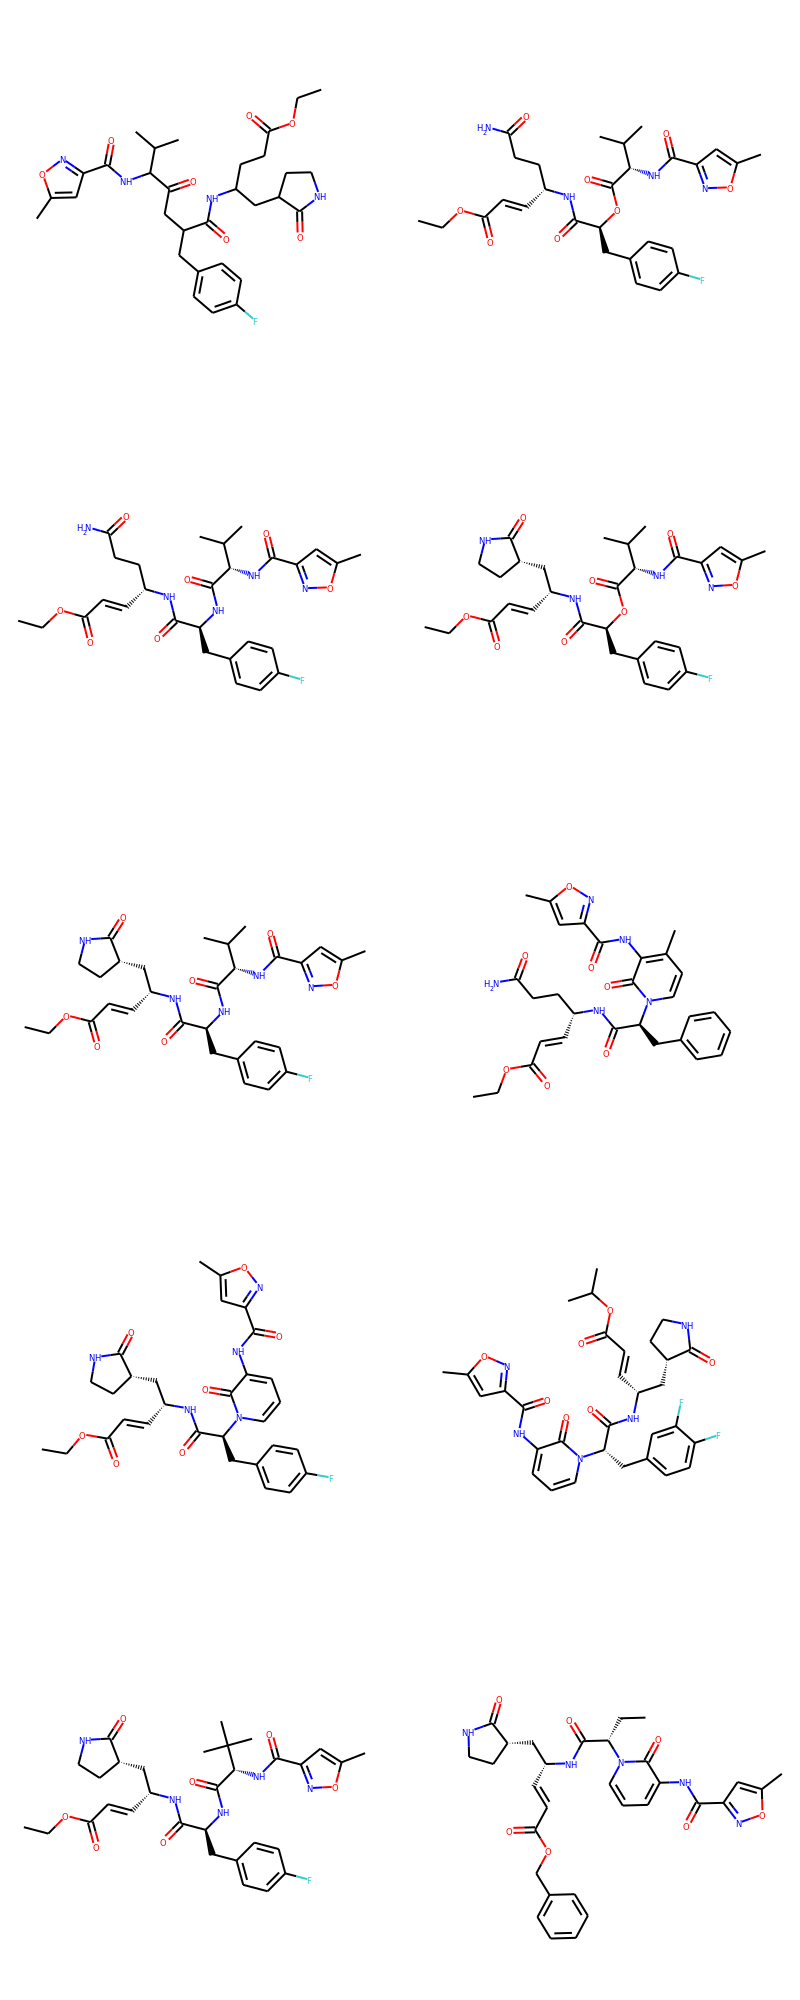

In [0]:
rdkit.Chem.Draw.MolsToGridImage(best_predicted_mols, molsPerRow=2, maxMols=100, subImgSize=(400, 400))

In [0]:
def write_to_pdb(m, name):
    m = Chem.AddHs(m)
    Chem.EmbedMolecule(m)
    w = Chem.rdmolfiles.PDBWriter(open("Docking/"+ str(name) + ".pdb", "w"))
    w.write(m)

In [0]:
for i in range(len(best_predicted_mols)):
    write_to_pdb(best_predicted_mols[i], "bp_" + str(i+1))

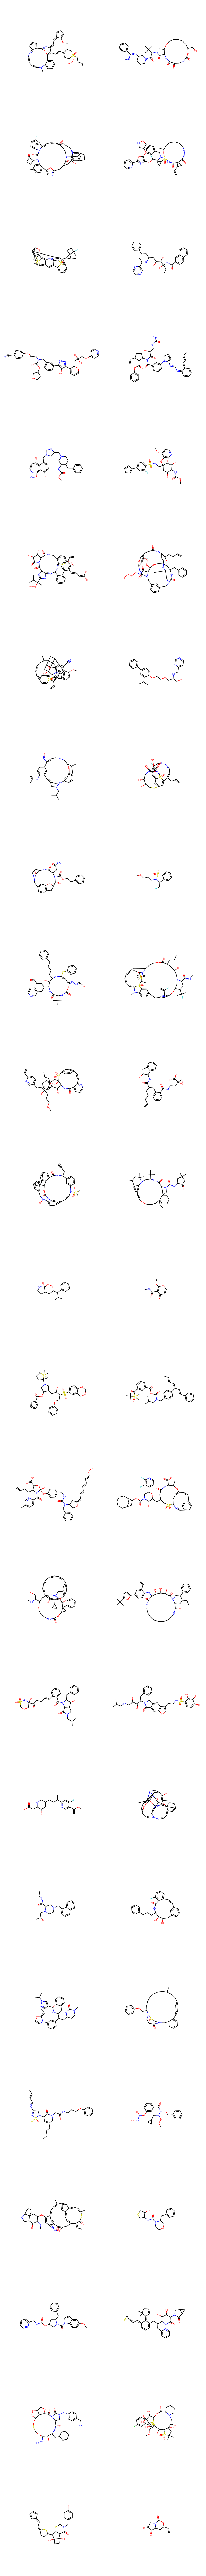

In [0]:
generated = pickle.load(open("Data/first_generated_smiles_zinc", "rb"))
generated = [Chem.MolFromSmiles(x) for x in generated]
rdkit.Chem.Draw.MolsToGridImage(generated, molsPerRow=2, maxMols=100, subImgSize=(400, 400))

In these 50 generated compounds, the ones that appeared at least the most visually similar to the n3 ligand (mainly just the small ones, which there aren't many) are: indexes: [5,6,9,32,33,34,36,38,44]

In [0]:
for i in [5,6,9,32,33,34,36,38,43,44]:
    write_to_pdb(generated[i], str(i))

After being prepared, the ligands were docked using autodock vina and the script multi_dock.sh to automate the process of docking many compounds. 

In [0]:
names = ["bp_1", "bp_2", "bp_3", "bp_4", "bp_5","bp_6", "bp_7", "bp_8", "bp_9", "bp_10"]
for name in names:
    f = open("Docking/conf_" + name + ".txt", "w+")
    f.write("receptor = /u/macdougt/Research/2019-nCov/Docking/6LU7_receptor_rigid.pdbqt\n")
    f.write("flex = /u/macdougt/Research/2019-nCov/Docking/6LU7_receptor_flex.pdbqt\n")
    f.write("ligand = /u/macdougt/Research/2019-nCov/Docking/" + name + ".pdbqt\n")

    f.write("out = /u/macdougt/Research/2019-nCov/Docking/out_" + name + ".pdbqt\n")
    f.write("log = /u/macdougt/Research/2019-nCov/Docking/log_" + name + ".txt\n")

    f.write("center_x = -11.963\n")
    f.write("center_y = 15.683\n")
    f.write("center_z = 69.193\n")

    f.write("size_x = 20\n")
    f.write("size_y = 24\n")
    f.write("size_z = 22\n")

    f.write("exhaustiveness = 80\n")

    f.write("cpu = 7\n")
    f.close()

### Scores of various compounds

For the predicted compounds

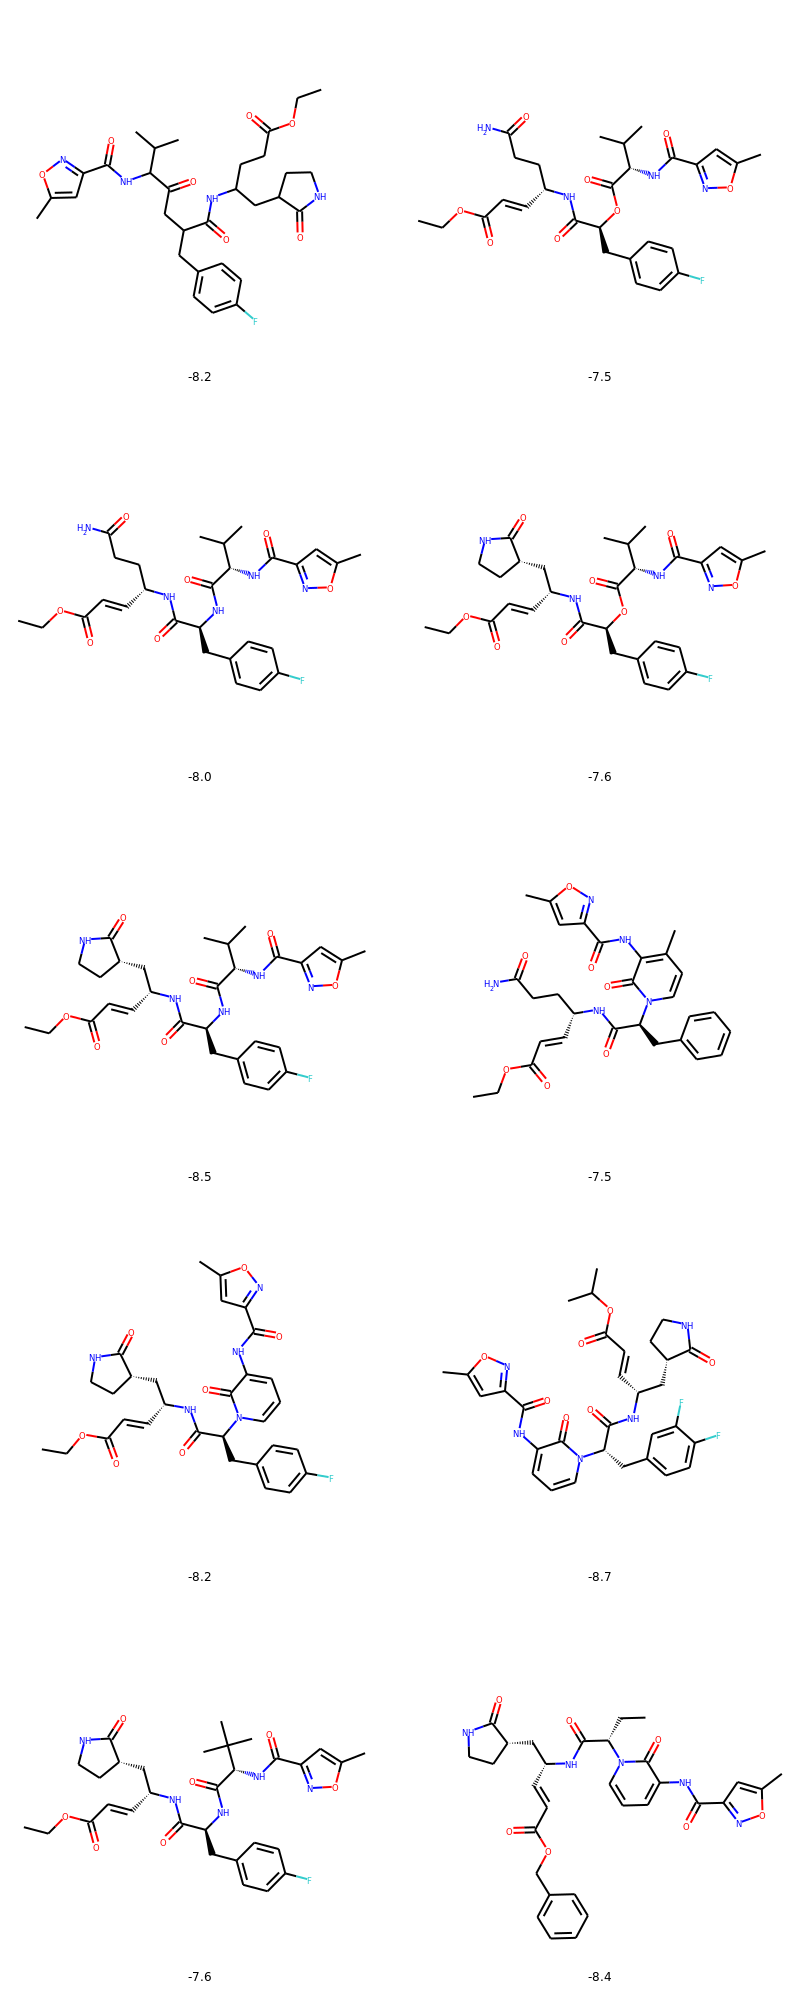

In [0]:
rdkit.Chem.Draw.MolsToGridImage(best_predicted_mols, molsPerRow=2, maxMols=100, subImgSize=(400, 400), legends=["-8.2", "-7.5", "-8.0", "-7.6", "-8.5", "-7.5", "-8.2", "-8.7", "-7.6", "-8.4"])

For the generated compounds

In [0]:
docked_generated = [generated[i] for i in [5,6,9,32,33,34,36,38,43,44]]

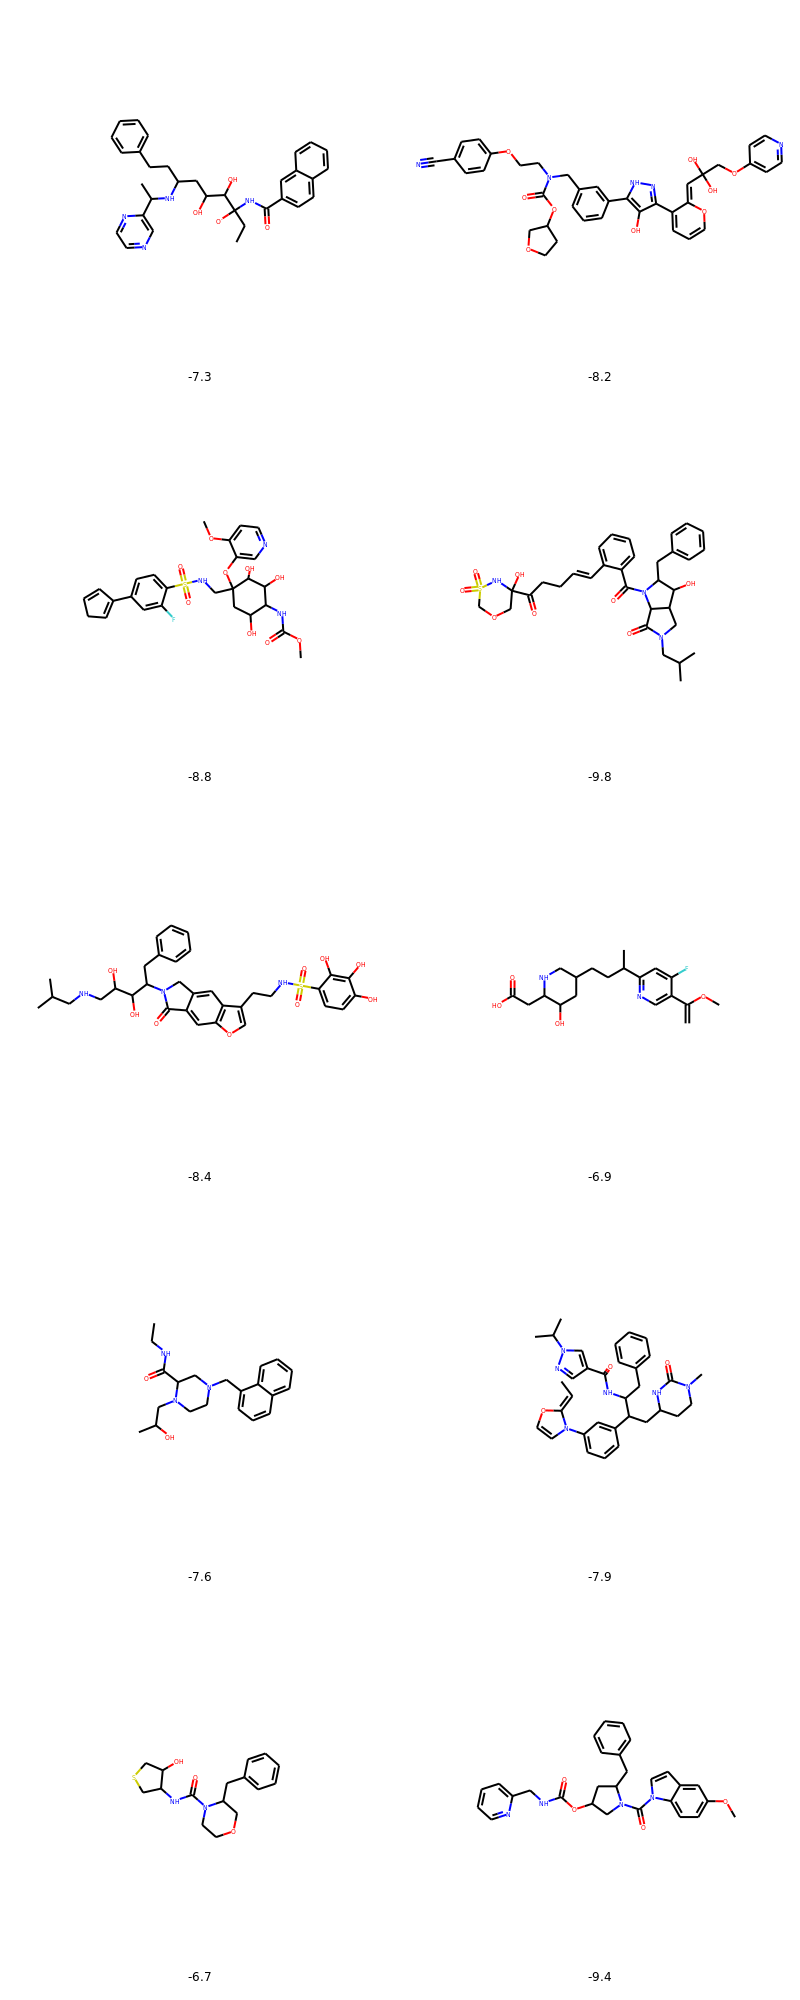

In [0]:
rdkit.Chem.Draw.MolsToGridImage(docked_generated, molsPerRow=2, maxMols=100, subImgSize=(400, 400), legends=["-7.3", "-8.2", "-8.8", "-9.8", "-8.4", "-6.9", "-7.6", "-7.9", "-6.7", "-9.4"])

Chosing the best scoring compound from these two schemes, we get the following compound from the prediction method, with a score of -8.7kcal/mol

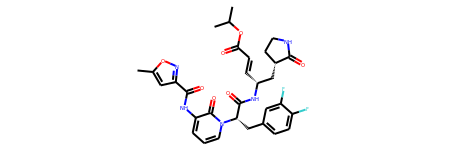

In [0]:
best_predicted_mols[7]

The best one from the generative mthod is shown below, with a score of -9.8 kcal/mol

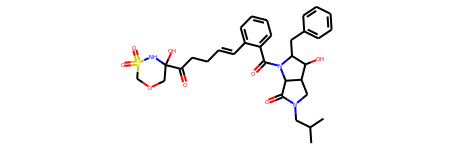

In [0]:
generated[32]

### Visualizing the high scoring compounds in the active site

The following is the highest scoring predicted compound mentioned above.

![bp_8_lowest_energy.png](attachment:bp_8_lowest_energy.png)

The following is the highest scoring generated compound mentioned above.

![candidate_8_lowest_energy.png](attachment:candidate_8_lowest_energy.png)

## Discussion and Conclusion

A predictive deep learning model was trained on a self-generated set of protease inhibitors, and the the pubchem literature was searched for 183 compounds that are somilar to the n3 ligand. Predictions were made on these compounds and those with the 10 best predictive scores were docked to the ligand. The highest scoring compound is shown above and has a score of -8.7kcal/mol

A generative deep learning model was trained on a self-generated set of protease inhibitors, and 50 new compounds were sampled from the latent space of the model. The 10 most promising compounds were docked to the ligand. The highest scoring compound is shown above and has a score of -9.8kcal/mol

The best compounds from each method show signicant gains over the baseline score of -7.9kcal/mol for the n3 ligand.

We would say that the high scoring compound from the predictive model should be investigated first, because since it was predicted using a test test of compounds from pubchem, this means that it is a chemically feasible compound, which is very important, which means that it could be obtained or made quickly, to be used right away. The generated compound did have a higher binding score, but it's a generated compound that might be difficult to make, even for an experienced chemist, it's difficult to say. 